# Identificacion de preguntas constantes en las entrevistas

## Trabajo 4.1

Usando cualquiera de las clusterizaciones del trabajo 3

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import numpy as np
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.draw import dispersion_plot
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from IPython.display import display, HTML

In [2]:
from Trabajo_1 import Entrevista

In [3]:
carpeta_entrevistas = "Datos (modificaciones manuales)"
carpeta_input = './/Resultados trabajo 3//'
trabajo_a_considerar = '3_5'

name_archivo_clusters = f'clusters_{trabajo_a_considerar}.csv'

### Lectura de entrevistas y preguntas

In [4]:
# guardas los objetos creados en una lista
entrevistas = []

# checar todos
for file in os.listdir('.\\' + carpeta_entrevistas):
    ruta_archivo = os.path.join('.\\' + carpeta_entrevistas, file)
    if os.path.isfile(ruta_archivo):
        # crear el objeto y meterlo a la lista
        entrevistas.append(Entrevista(carpeta_entrevistas, file, debug = 0))
        
num_entrevistas = len(entrevistas)
print(f'Se tienen {num_entrevistas} entrevistas')

preguntas = []

for e in entrevistas:
    # añadir las preguntas de esta entrevista
    preguntas.extend(e.get_preguntas())


print(f'Se tienen {len(preguntas)} preguntas en total')

Se tienen 38 entrevistas
Se tienen 3934 preguntas en total


### Lectura de los clusters a usar

In [5]:
# leer el archivo
file_clusters = pd.read_csv(carpeta_input + name_archivo_clusters)
file_clusters = file_clusters.set_index('pregunta')

# ver que se tengan tantas preguntas en ese arhivo
# como preguntas se tienen ahorita
assert file_clusters.shape[0] == len(set(preguntas))

In [6]:
# crear un diccionario de pares (pregunta, cluster)
dict_pregunta_cluster = {}

for p in preguntas:
    dict_pregunta_cluster[p] = file_clusters.loc[p, 'cluster']

In [7]:
# identificar los clusters que se tienen
clusters = sorted(list((file_clusters['cluster'].unique())))

In [8]:
# pregunta que toma una lista de preguntas
# devuelve una lista con los clusters a los que pertenecen

def clusterizar(lista_preguntas):
    
    clusters = [dict_pregunta_cluster[p] for p in lista_preguntas]
    
    return clusters

###  "Calidad de un cluster"

Mientras mas baja la metrica, mejor

In [9]:
# hacer un diccionario donde las llaves sean los clusters
# los valores son una lista de pares (pregunta, entrevista_donde_ses_dijo)
dict_preguntas_entrevista = {}

In [10]:
def metrica_cluster(cluster_interes, entrevistas = entrevistas):
    # recive un clsuter de interes
    # da una metrica de la calidad del cluster o clusters
    # mientras mas bajo mejor
    # aprovecha para llenar las entradas corresponientes en:
    # dict_preguntas_entrevista
    
    # lista de los pares (pregunta, entrevista_donde_ses_dijo)
    # para añadir al diccionario
    pregunta_entrevista = []
    
    # por cada entrevista, poner un valor de metrica
    metrica_por_entrevista = []
    
    # iterar las entrevistas
    for idx, e in enumerate(entrevistas):
        
        # obtener preguntas de la entrevista
        preguntas_e = e.get_preguntas()
        # ver a que clusters perteneces
        clusters_e = clusterizar(preguntas_e)
        
        # ir poniendo las posiciones relativas de las aparisiones
        # del cluster de interes dentro de la entrevista
        apariciones = []
        
        # iterar las preguntas
        # mejor dicho, los clusters a los que pertenecen
        for i, cluster in enumerate(clusters_e):
            
            # ver si el cluster es de interes
            if cluster == cluster_interes:
                
                # se guarda la posicion relativa de esta aparicion
                apariciones.append(i/len(clusters_e))
                
                # se agrega el par (pregunta, entrevista)
                pregunta_entrevista.append((preguntas_e[i], idx))

        # ya se termino de ver la entrevista
        # si se tuvo al menos una pregunta de nuestro cluster de interes
        if len(apariciones) > 0:
            
            apariciones = np.array(apariciones)
            # tomar las "cajitas" donde aparecio (numeros enteros del 1 al 10)
            cajitas = [1 + int(a) for a in apariciones*10]
            
            # calcular la entriopia de la distribucion de las pregutnas en las cajitas
            entr = entropy(cajitas)

            # la metrica de la entrevista crece si la entriopia crece
            # tambien crece si se tienen muchas cajitas
            metrica_por_entrevista.append(math.e**(entr) * len(set(cajitas)))

    # se terminan de ver las entrevistas
    
    # guardar la lista de pares (pregunta, entrevista_donde_ses_dijo) en el dict
    dict_preguntas_entrevista[cluster_interes] = pregunta_entrevista
    
    # tomar las metricas por entrevista
    # hacer que sean 38, se acompleta con el menor
    minimo = min(metrica_por_entrevista)
    metrica_por_entrevista = metrica_por_entrevista + [minimo]*(len(entrevistas)-len(metrica_por_entrevista))
    
    # la metrica total es el promedio de estas
    m = np.array(metrica_por_entrevista).mean()
    
    return m

###  Funciones de visualizacion

In [11]:
# funcion auxiliar que da una lista de n colores
def get_colors(n):
    # Obtener la lista de colores predeterminada
    default_colors = list(mcolors.TABLEAU_COLORS.values())

    # Verificar si hay suficientes colores predeterminados para n elementos
    if n <= len(default_colors):
        return default_colors[:n]
    else:
        # Si no hay suficientes colores predeterminados, generar más colores
        additional_colors = list(mcolors.CSS4_COLORS.values())
        return default_colors + additional_colors[:n - len(default_colors)]

In [12]:
# dado uno o varios clusters, se grafica su presencia en las entrevistas

def ver_clusters(clusters_interes, entrevistas = entrevistas, ax = None, color = 'blue', label = None):
    
    # sino se pasa un ax, se crea uno y se pone el titulo segun los clusters que se esten viendo
    if ax is None:
        _, ax = plt.subplots()
        ax.set_title('Clusters ' + ' '.join([str(p) for p in clusters_interes]))
        
    # para ver si se pone un legend al plot
    poner_label = False
    if label is not None:
        poner_label = True
    
    
    # iterar las entrevistas
    for idx, e in enumerate(entrevistas):
        

        # obtener preguntas de la entrevista
        preguntas_entrevista = e.get_preguntas()
        # ver a que clusters perteneces
        clusters_entrevista = clusterizar(preguntas_entrevista)
        
        # iterar las preguntas, bueno, en sus clusters
        for i, cluster in enumerate(clusters_entrevista):
            
            # ver si el cluster pertenece a los que nos interesan
            if cluster in clusters_interes:
                # si lo es
                # hacer el cuadrado que se va a marcar
                
                # los limites en x depende de la posicion relativa de esta pregunta en la entrevista
                # cada pergunta representa un subintervalo de [0, 1] obtener el de esta pregunta
                # cada uno de estos intervalos es uniforme y mide h
                h = 1/len(clusters_entrevista)
                # el intervalo de esta pregunta es logicamente [i*h, (i+1)*h]
                inicio_x = i*h
                fin_x = (i+1)*h
                
                # tambien se ponen los limites de y
                # este depende del numero de entrevista
                inicio_y =  idx-0.3
                fin_y =     idx+0.3
                
                # usando los limites, se hace el cuadrado
                x = [inicio_x, inicio_x, fin_x, fin_x, inicio_x]
                y = [inicio_y, fin_y, fin_y, inicio_y, inicio_y]
                # ver si se pone label o no
                if poner_label:
                    ax.fill(x, y, color, label = label)
                    poner_label = False # pues ya se puso
                else:
                    ax.fill(x, y, color)
                
                
    # terminar detalles del grafico
    ax.set_yticks(list(range(len(entrevistas))), ['e ' + str(idx) for idx in range(len(entrevistas))])
    ax.set_ylim(-1, len(entrevistas))
    ax.set_xlim(-0.05, 1.05)
    if label is not None:
        ax.legend()

In [13]:
def imprimir_texto_con_color(texto, color_fondo):
    # Calcula el color del texto en función del color de fondo
    if color_fondo.startswith("#"):
        r, g, b = tuple(int(color_fondo[i:i+2], 16) for i in (1, 3, 5))
        luminosidad = (r * 0.299 + g * 0.587 + b * 0.114) / 255
        color_texto = "black" if luminosidad > 0.5 else "white"
    else:
        color_texto = "black"  # Color de texto predeterminado para colores no hexadecimales
    
    # Crear cadena de texto HTML con estilo
    estilo = f"color:{color_texto}; background-color:{color_fondo};"
    mensaje_html = f'<div style="{estilo}">{texto}</div>'
    
    # Mostrar el mensaje en la Jupyter Notebook
    display(HTML(mensaje_html))

In [14]:
# igual que la funcion anterior, pero tambien se le da un cluster c
# pone como mensaje emergente a las demas preguntas del mismo cluster
def imprimir_texto_con_color_mensaje_emergente(texto, color_fondo, c):
    # Calcula el color del texto en función del color de fondo
    if color_fondo.startswith("#"):
        r, g, b = tuple(int(color_fondo[i:i+2], 16) for i in (1, 3, 5))
        luminosidad = (r * 0.299 + g * 0.587 + b * 0.114) / 255
        color_texto = "black" if luminosidad > 0.5 else "white"
    else:
        color_texto = "black"  # Color de texto predeterminado para colores no hexadecimales

    # Crear cadena de texto HTML con estilo y mensaje emergente
    estilo = f"color:{color_texto}; background-color:{color_fondo};"
    
    # tomar las preguntas del cluster y ponerlas como mensaje emergente
    p_e = dict_preguntas_entrevista[c]
    p = [pe[0] for pe in p_e]
    sp = ' | '.join(p)
    mensaje_emergente = f'Cluster {c}: {sp}'
    
    mensaje_html = f'<div style="{estilo}" title="{mensaje_emergente}">{texto}</div>'

    # Mostrar el mensaje en la Jupyter Notebook
    display(HTML(mensaje_html))


### Evaluar la calidad de los clusters

In [15]:
# hacer una lista de pares (metrica_cluster, cluster)
metricas_cluster = []

for cluster in clusters:
    metricas_cluster.append((metrica_cluster(cluster), cluster))
    
# ordenar segun la metrica
metricas_cluster = sorted(metricas_cluster)

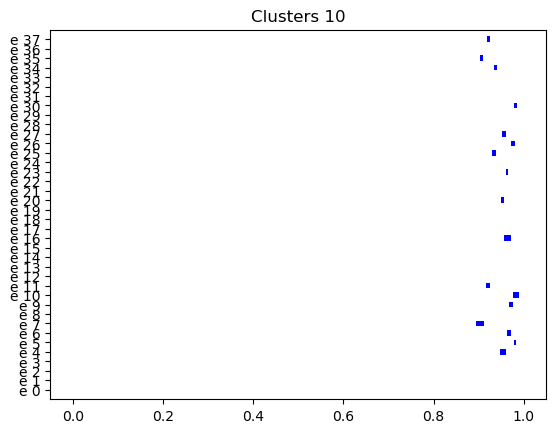

Metrica del cluster 10: 1.0


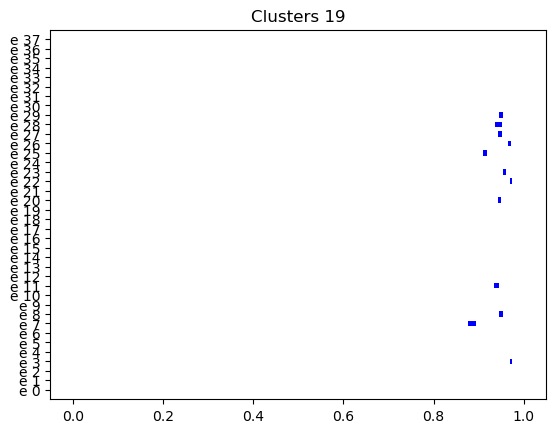

Metrica del cluster 19: 1.0


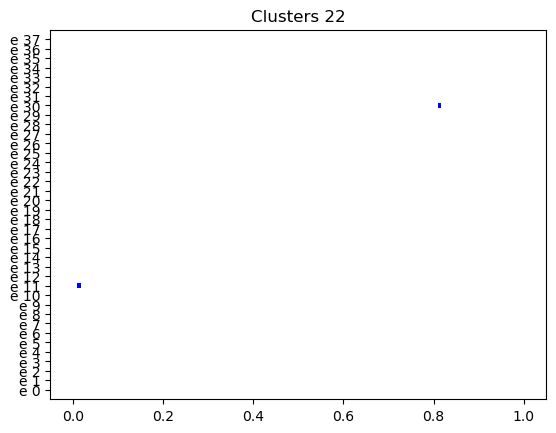

Metrica del cluster 22: 1.0


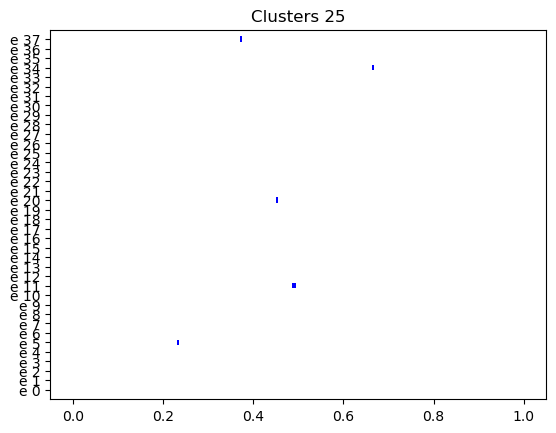

Metrica del cluster 25: 1.0


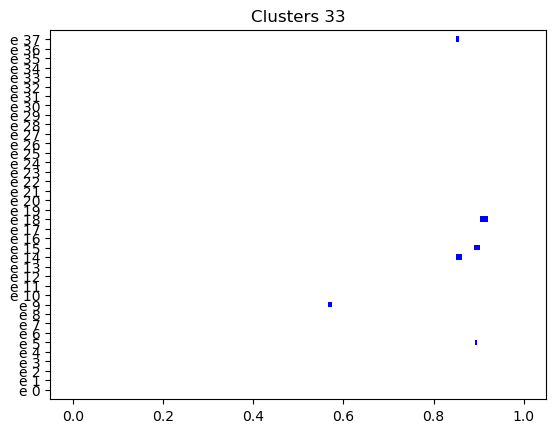

Metrica del cluster 33: 1.0


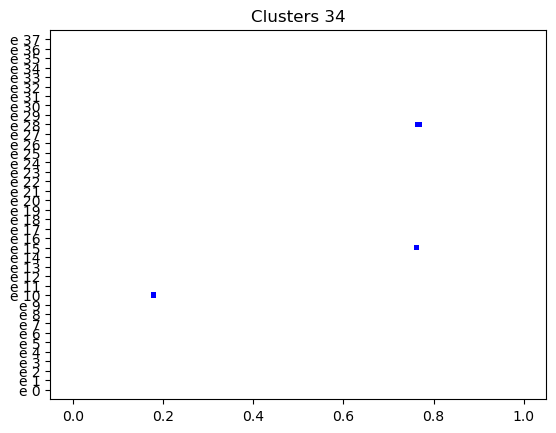

Metrica del cluster 34: 1.0


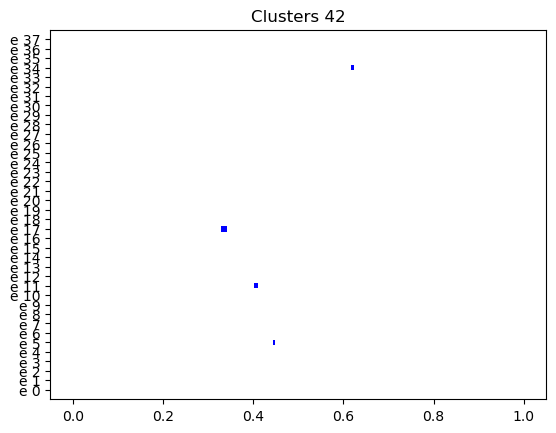

Metrica del cluster 42: 1.0


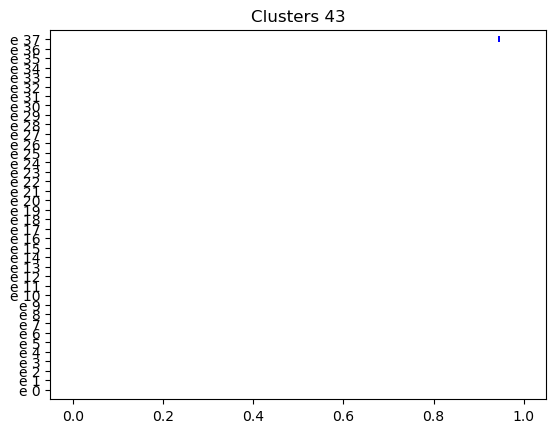

Metrica del cluster 43: 1.0


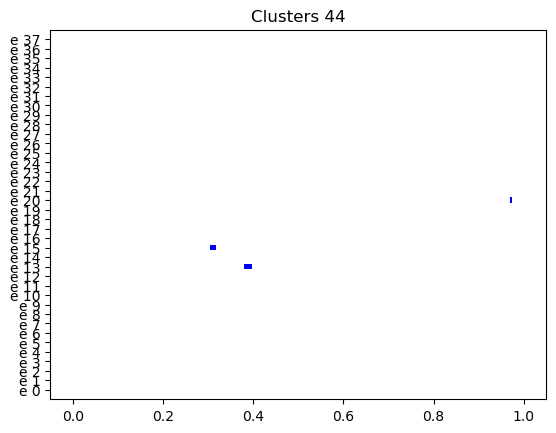

Metrica del cluster 44: 1.0


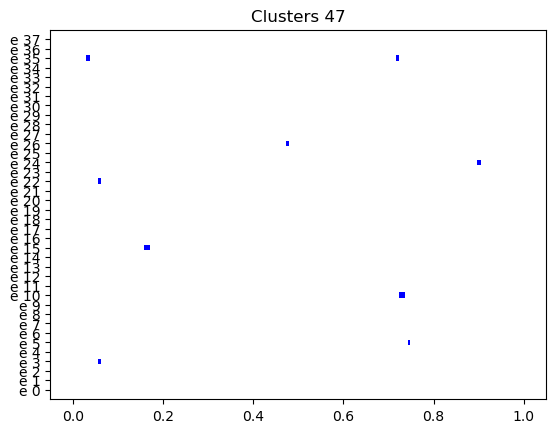

Metrica del cluster 47: 1.0482847990069333


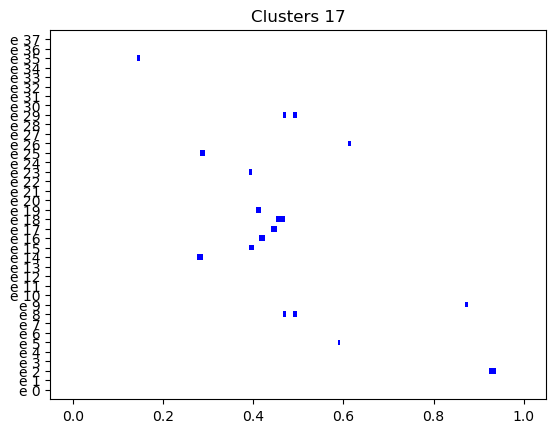

Metrica del cluster 17: 1.0526315789473684


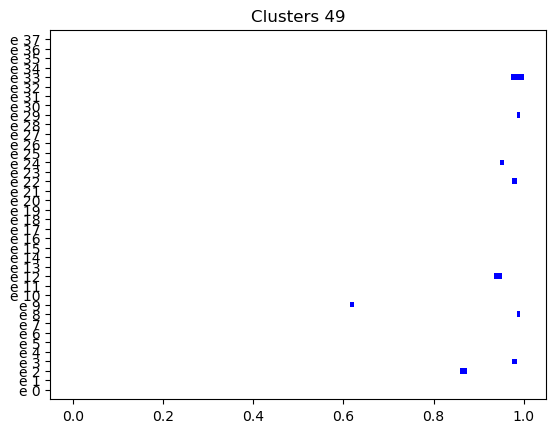

Metrica del cluster 49: 1.0526315789473684


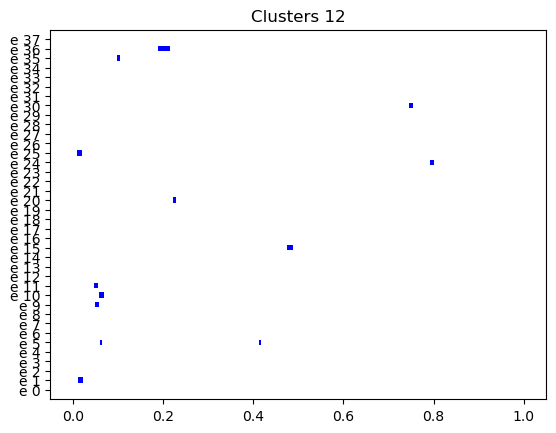

Metrica del cluster 12: 1.0562732938533788


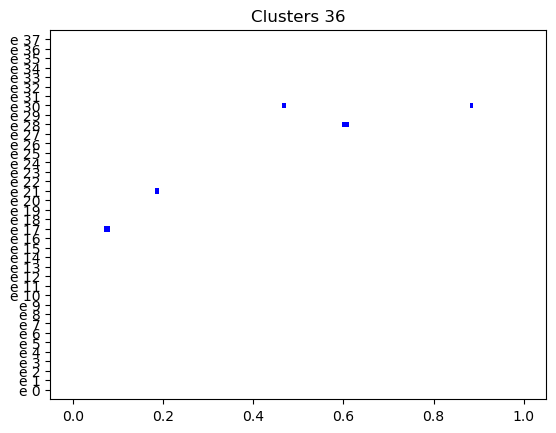

Metrica del cluster 36: 1.0746793973998596


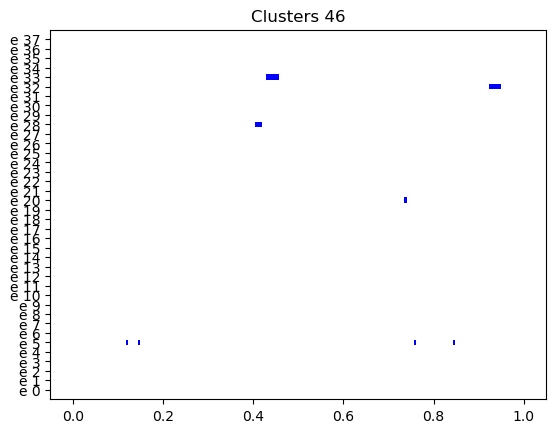

Metrica del cluster 46: 1.2302640622431982


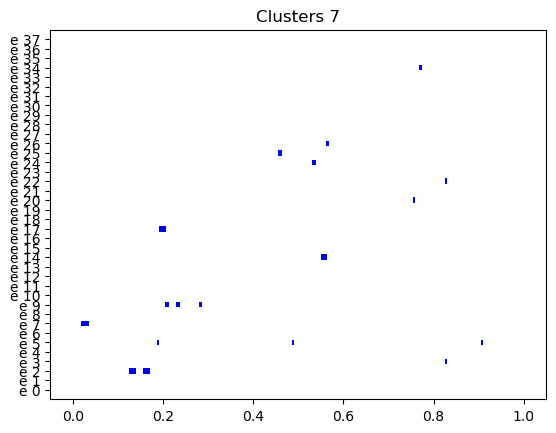

Metrica del cluster 7: 1.251495765790441


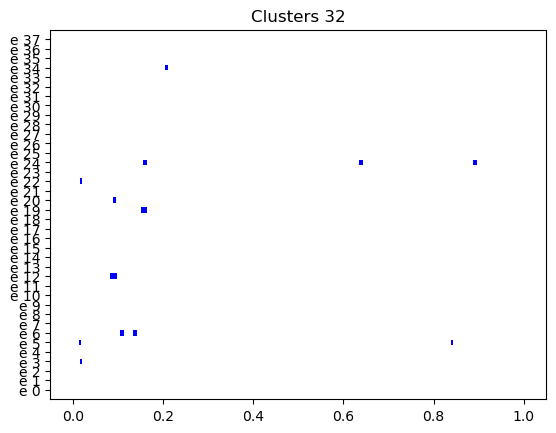

Metrica del cluster 32: 1.2523086333743603


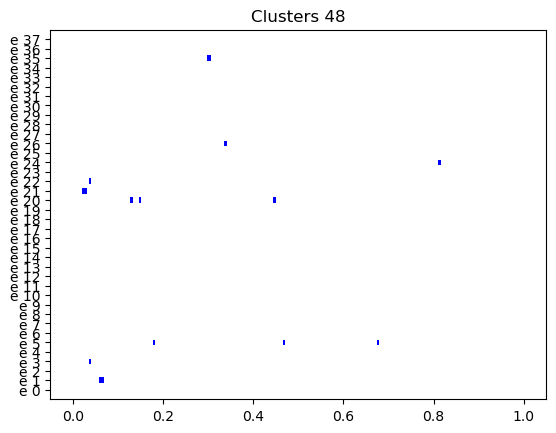

Metrica del cluster 48: 1.3026774507702918


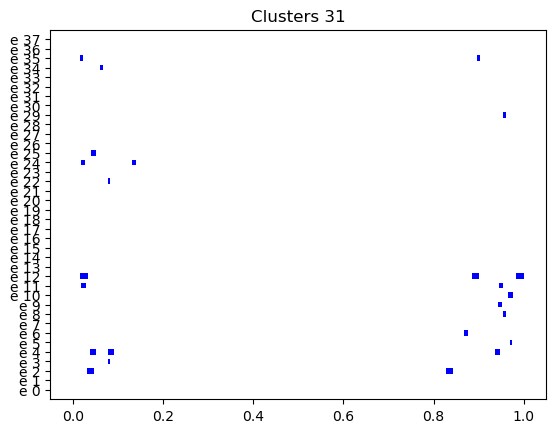

Metrica del cluster 31: 1.4371133929232671


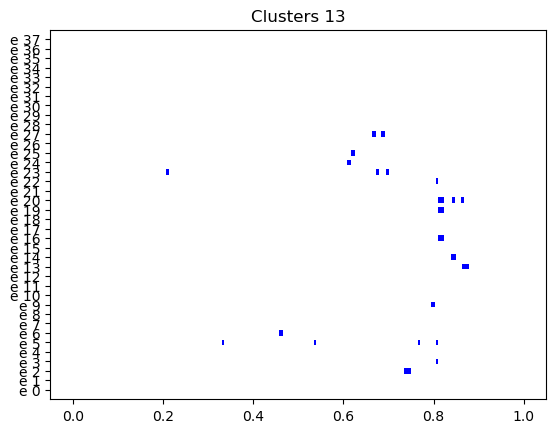

Metrica del cluster 13: 1.6045816977417824


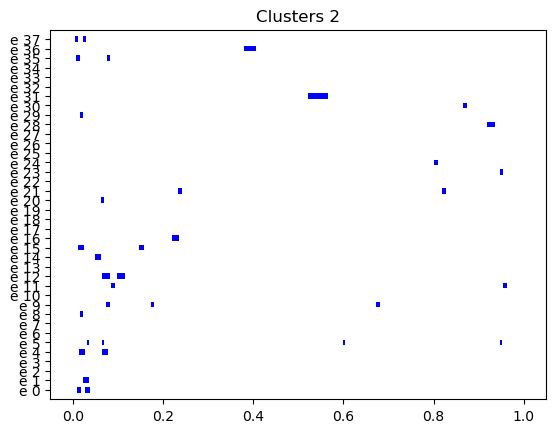

Metrica del cluster 2: 1.6572027402469345


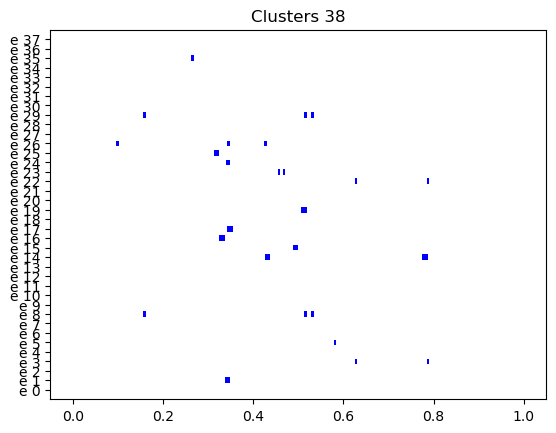

Metrica del cluster 38: 1.671085314023598


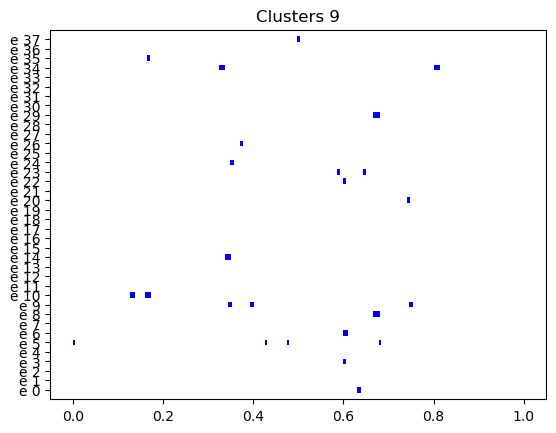

Metrica del cluster 9: 1.6953126672251972


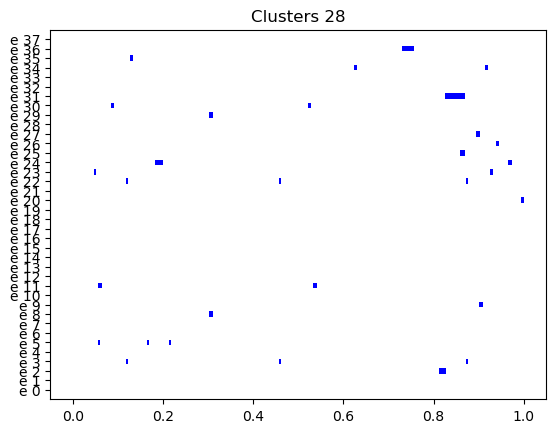

Metrica del cluster 28: 1.8639435040766803


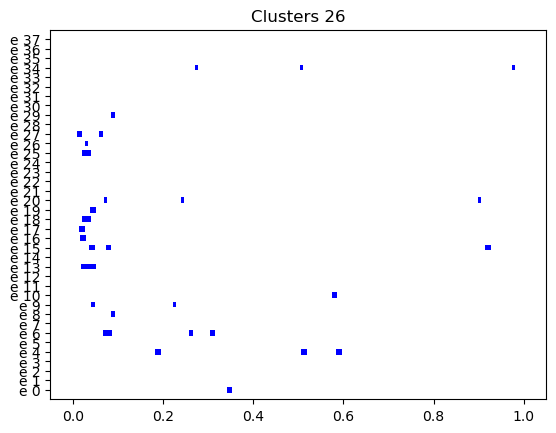

Metrica del cluster 26: 1.9029943843695185


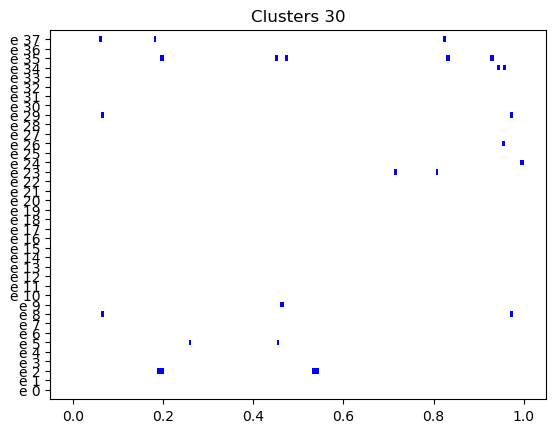

Metrica del cluster 30: 1.9135056941661797


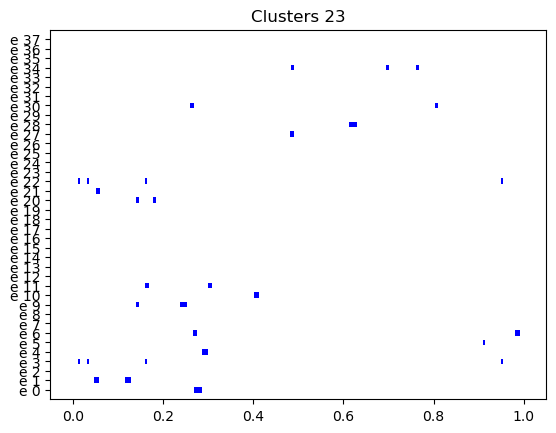

Metrica del cluster 23: 2.0018993848591804


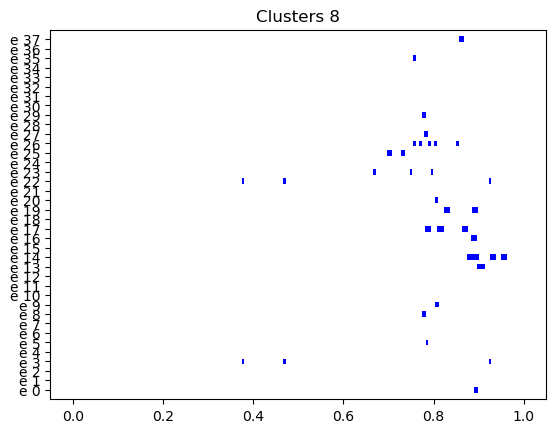

Metrica del cluster 8: 2.1982822188564963


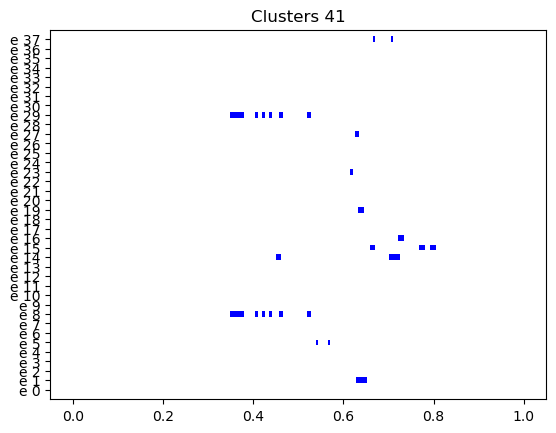

Metrica del cluster 41: 2.745058951229663


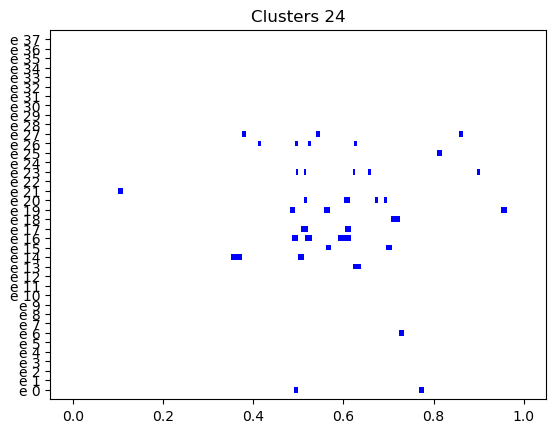

Metrica del cluster 24: 3.060373367661289


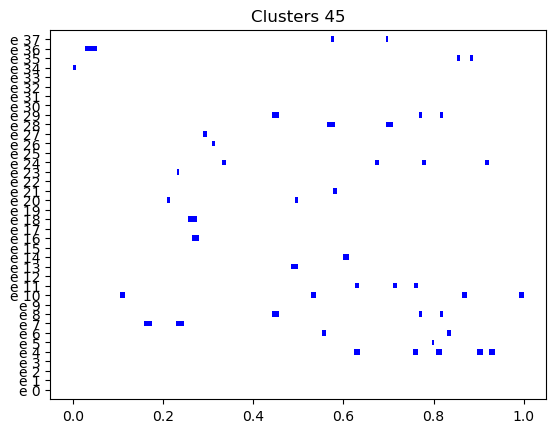

Metrica del cluster 45: 3.318042397701316


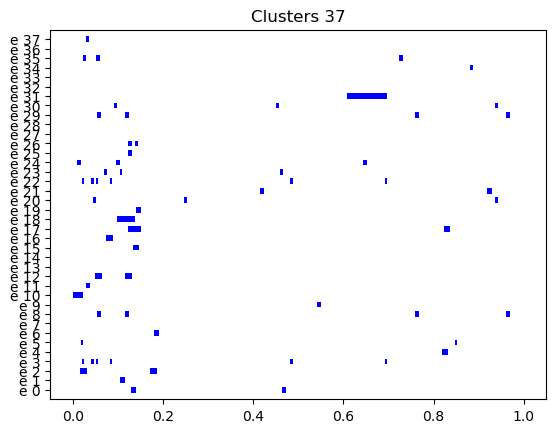

Metrica del cluster 37: 3.3713204447113934


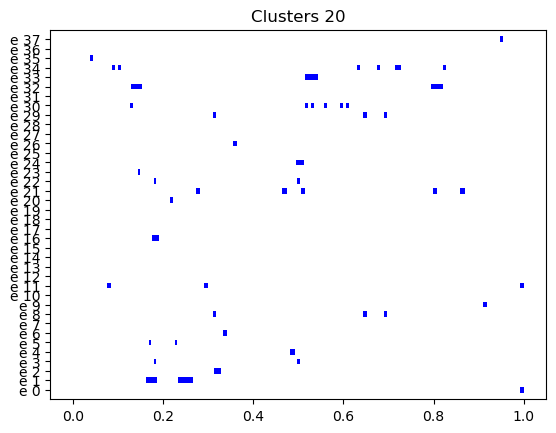

Metrica del cluster 20: 3.580081121013782


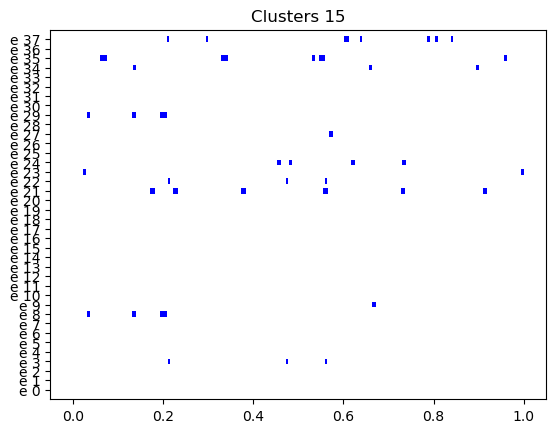

Metrica del cluster 15: 4.687293683552366


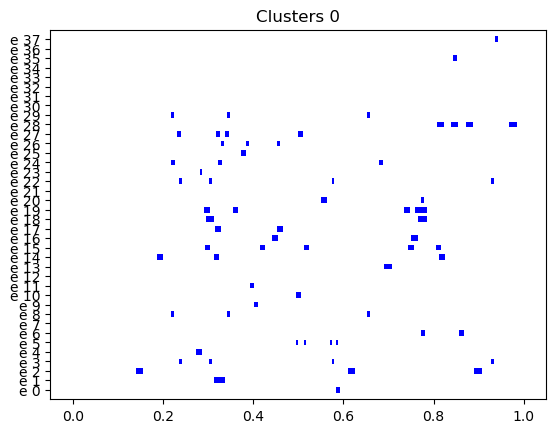

Metrica del cluster 0: 4.8156267237967105


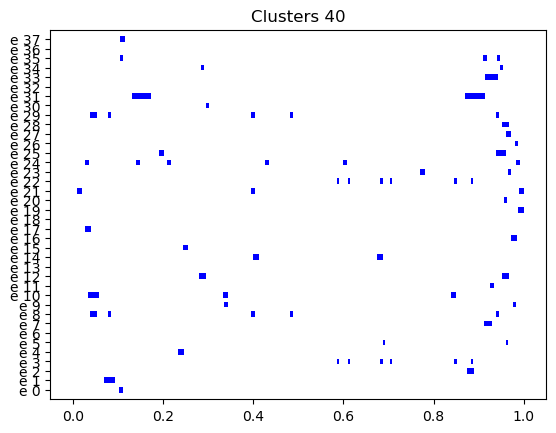

Metrica del cluster 40: 4.904959928838754


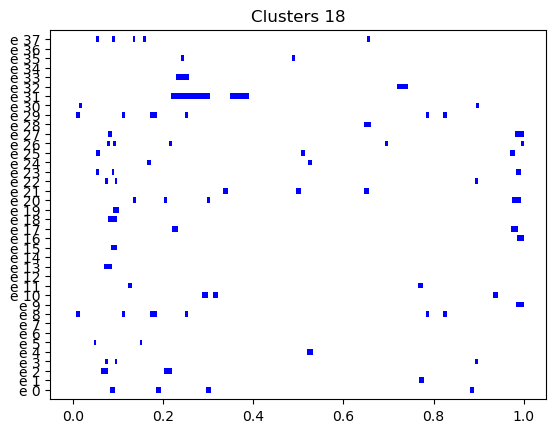

Metrica del cluster 18: 5.116044645908024


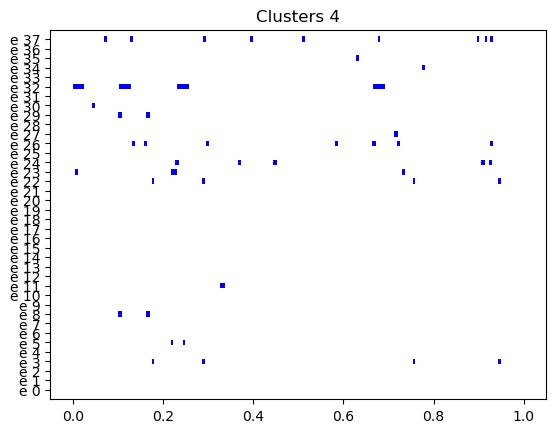

Metrica del cluster 4: 5.192038322653538


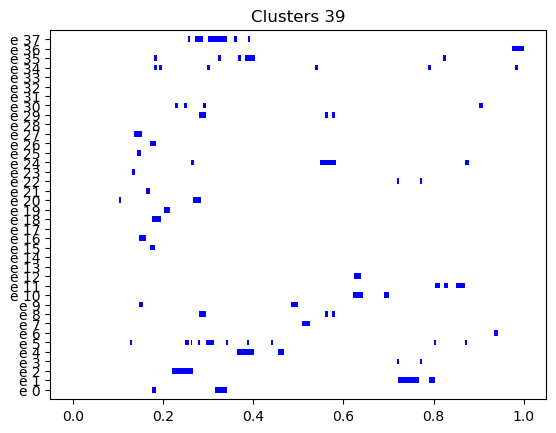

Metrica del cluster 39: 6.389210711972403


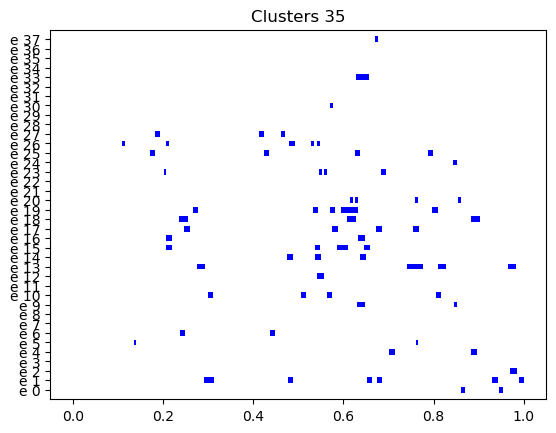

Metrica del cluster 35: 6.559285790291728


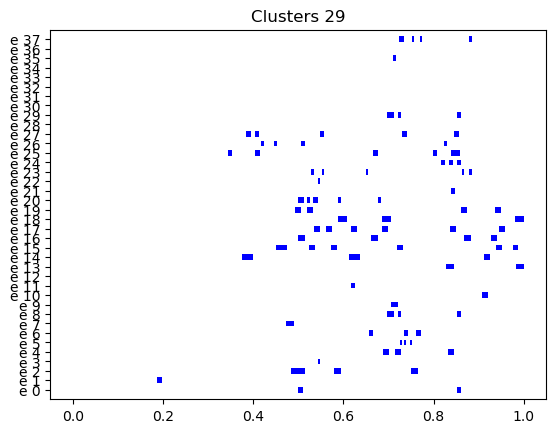

Metrica del cluster 29: 7.63566717130614


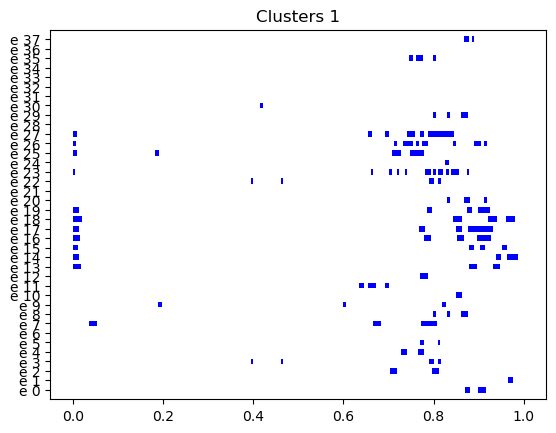

Metrica del cluster 1: 10.008671109249255


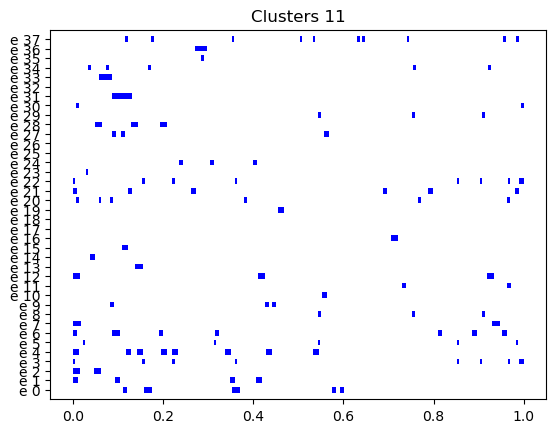

Metrica del cluster 11: 10.535525211365657


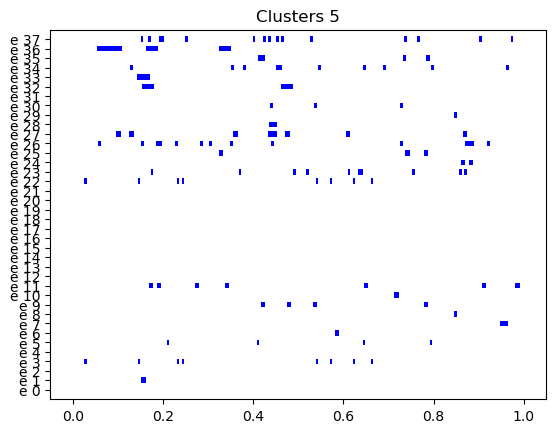

Metrica del cluster 5: 14.256139109059417


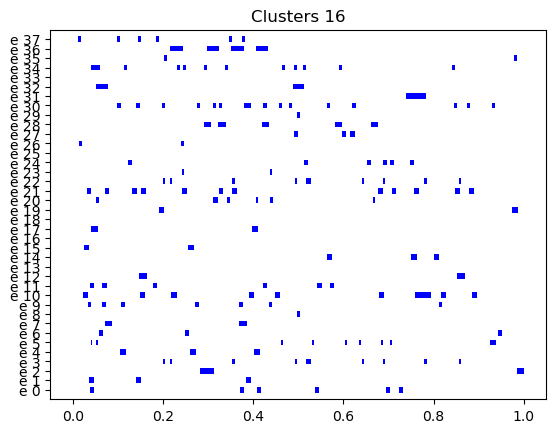

Metrica del cluster 16: 21.135430695403613


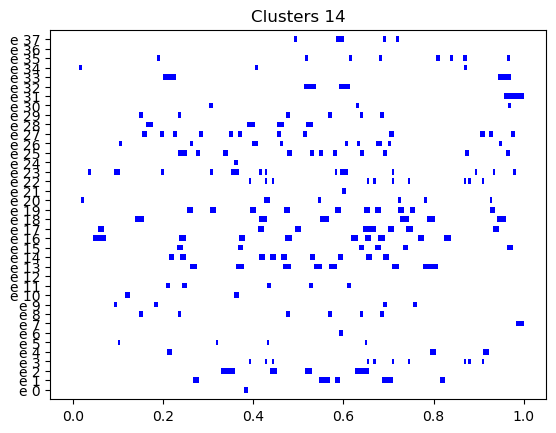

Metrica del cluster 14: 27.760763512679194


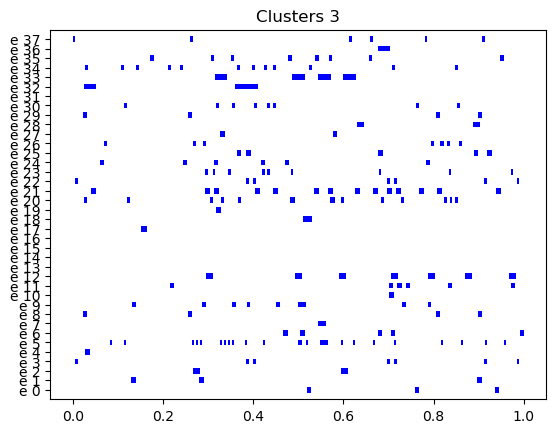

Metrica del cluster 3: 27.886502395272593


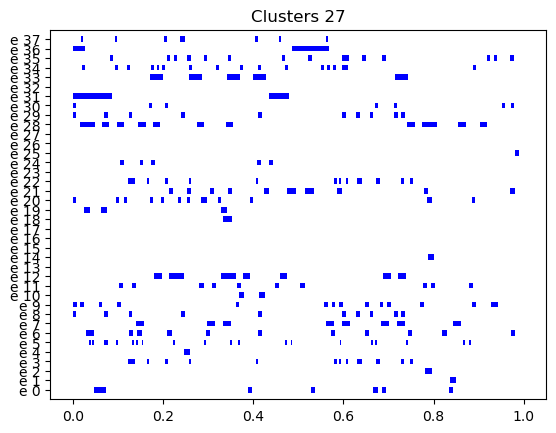

Metrica del cluster 27: 35.32558757906078


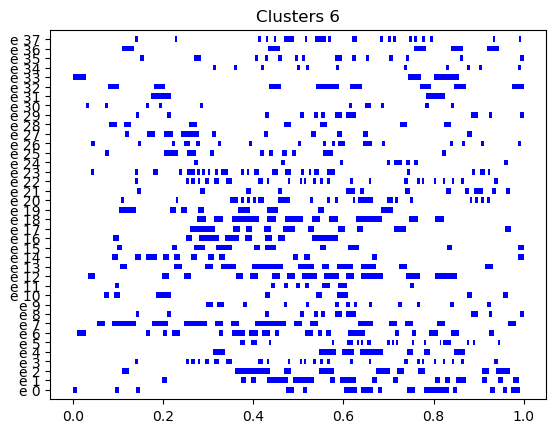

Metrica del cluster 6: 120.53621072241343


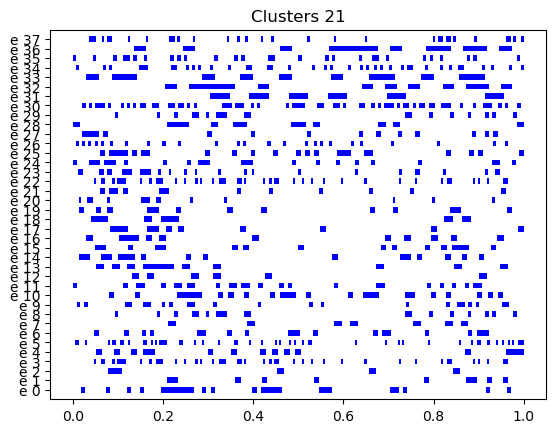

Metrica del cluster 21: 153.57289325857337


In [16]:
# ver los clusters, de mejor a peor


for m_c in metricas_cluster:
    
    # ver el grafico del cluster
    ver_clusters([m_c[1]])
    plt.show()
    
    # imprimir la metrica
    print(f'Metrica del cluster {m_c[1]}: {m_c[0]}')

### Filtrar los clusters que sean "buenos"

In [17]:
# maximo de metrica que debe tener para considerarse bueno
max_metrica = 7

# minimo numero de entrevistas en las que debe apareces para considerarse bueno
min_presencia = 1

# minimo de preguntas que debe tener para considerarse bueno
# ojo, aca son preguntas, no tipo de pregutnas
min_preguntas = 1

In [18]:
# poner los buenos clusters en una lista
buenos_clusters = []


# iterar los pares de (metrica, cluster)
for mc in metricas_cluster:
    
    # tomar la metrica
    m = mc[0]
    
    # tomar el cluster
    c = mc[1]
    
    # tomar su lista de (pregunta, indice_entrevista)
    lista_p_e = dict_preguntas_entrevista[c]
    
    # tomar las preguntas
    p = [p_e[0] for p_e in lista_p_e]
    
    # ver el numero de pregutnas (notar que se cuentan repetidas)
    num_p = len(p)
    
    # tomar las entrevistas
    e = [p_e[1] for p_e in lista_p_e]
    
    # ver el numero de entrevistas en las que sale
    presencia = len(set(e))
    
    #print('Cluster', c)
    #print('metrica', m)
    #print('Num entrevistas', presencia)
    #print('Num pregutnas', num_p)
    
    # ver si es bueno
    if m <= max_metrica and presencia >= min_presencia and num_p >= min_preguntas:
        # agregar a la lista
        #print('Se considera bueno')
        buenos_clusters.append(c)
        
    #print("-"*100)

### Ver los clusters que son "buenos"

In [19]:
for c in buenos_clusters:
    
    print('Cluster', c)
    
    # obtener las preguntas
    preguntas_c = [p_e[0] for p_e in dict_preguntas_entrevista[c]]
    # obtener las entrevistas
    entrevistas_c = [p_e[1] for p_e in dict_preguntas_entrevista[c]]
    
    # tomar sin repetidos
    preguntas_unicas_c = list(set(preguntas_c))
    entrevistas_unicas_c = list(set(entrevistas_c))
    
    print(" ")
    print(f'Aparece en {len(entrevistas_unicas_c)} entrevistas')
    print(f'Tiene {len(preguntas_c)} preguntas en estas entrevistas')
    print(f'Que vienen de {len(preguntas_unicas_c)} tipos de preguntas')
    print(" ")
    print('Tipo de preguntas:')
    print(preguntas_unicas_c)
    
    print('-'*100)
    

Cluster 10
 
Aparece en 17 entrevistas
Tiene 17 preguntas en estas entrevistas
Que vienen de 9 tipos de preguntas
 
Tipo de preguntas:
['¿Religión, qué religión tienes?', '¿Religión?', 'Religión?', '¿Cuál es tu religión?', '¿Su religión?', '¿Qué religión tienes?', '¿Tu religión?', 'Tu religión qué, ¿cuál es? Si tienes, si no tienes puedes decir “no tengo”.', 'Este, ¿tu religión?']
----------------------------------------------------------------------------------------------------
Cluster 19
 
Aparece en 12 entrevistas
Tiene 12 preguntas en estas entrevistas
Que vienen de 5 tipos de preguntas
 
Tipo de preguntas:
['¿tu estado civil casado?', '¿Tu estado civil?', 'Tu situación, ¿tu estado civil?', '¿Estado civil?', '¿Su estado civil?']
----------------------------------------------------------------------------------------------------
Cluster 22
 
Aparece en 2 entrevistas
Tiene 2 preguntas en estas entrevistas
Que vienen de 2 tipos de preguntas
 
Tipo de preguntas:
['Del Salvador. ¿Cuánd

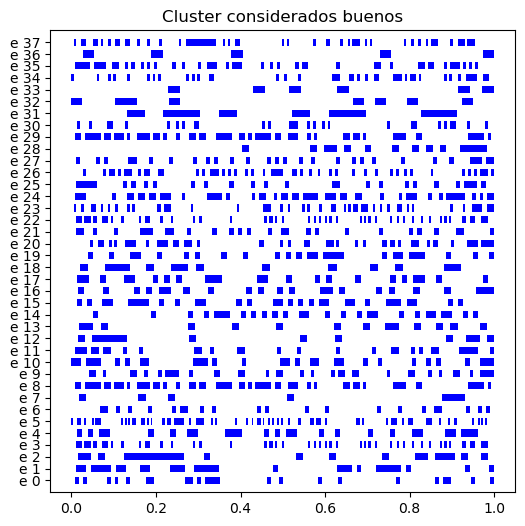

In [20]:
# ver todos los clusters con el mismo color


fig, ax = plt.subplots(figsize = (6, 6))

ver_clusters(buenos_clusters, ax = ax)

ax.set_title('Cluster considerados buenos')
plt.show()

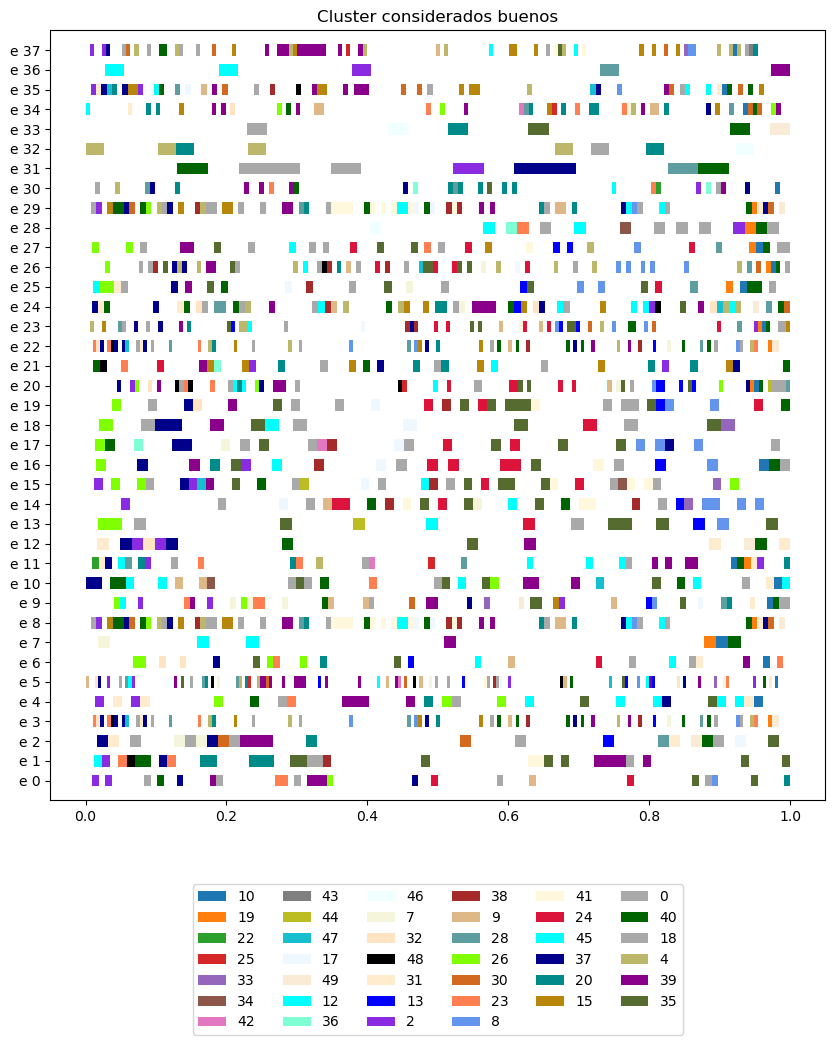

In [21]:
# ver todos los clusters con colores distintos

fig, ax = plt.subplots(figsize = (10, 10))

# obtener un color por cada cluster "bueno"
colores_buenos_clusters = get_colors(len(buenos_clusters))

# por cada cluster bueno, graficar sus preguntas con su respectivo color
for idx, c in enumerate(buenos_clusters):
    ver_clusters([c], ax = ax, label = c, color = colores_buenos_clusters[idx])

# Colocar la leyenda debajo de la gráfica
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
ax.set_title('Cluster considerados buenos')
plt.show()

In [22]:
idx = 17

e = entrevistas[idx]
preguntas_e = e.get_preguntas()
clusters_e = clusterizar(preguntas_e)

for p, c in zip(preguntas, clusters_e):
    
    if c in buenos_clusters:
        indice_buen_cluster = buenos_clusters.index(c)
        imprimir_texto_con_color_mensaje_emergente(p, colores_buenos_clusters[indice_buen_cluster], c)
        
    else:
        imprimir_texto_con_color(p, "white")

## ¿¿HACER CLUSTERS DE CLUSTERS ??

In [23]:
num_clusters = len(buenos_clusters)
print(f'Se tienen {num_clusters} clusters buenos')

Se tienen 40 clusters buenos


In [24]:
# para cada cluster, representarlo en un vector de k etradas
k = 10

# ir poniendo los vectores en una lista
vectores_clusters = []

# construir el vector de cada cluster
# este esta dado por la distribucion de las preguntas de este cluster
for c in buenos_clusters:
    
    # ir poniendo las posiciones relativas de las aparisiones
    apariciones = []

    # iterar las entrevistas
    for idx, e in enumerate(entrevistas):

        # obtener preguntas de la entrevista
        preguntas_e = e.get_preguntas()
        # ver a que clusters perteneces
        clusters_e = clusterizar(preguntas_e)

        # iterar las preguntas
        # mejor dicho, los clusters a los que pertenecen
        for i, cluster in enumerate(clusters_e):

            # ver si el cluster es de interes
            if cluster == c:

                # se guarda la posicion relativa de esta aparicion
                apariciones.append(i/len(clusters_e))

    # poner las posiciones relativas de las apariciones en  un array
    apariciones = np.array(apariciones)

    # hacer que sean numeros enteros de 1 a k
    apariciones = [int(k*a) + 1 for a in apariciones]

    # hacer la variable del vector de este cluster
    # primero llenar con zeros
    vector_c = np.zeros(k)

    # ahora se llena segun los numero en apariciones
    for a in apariciones:
        # recordar que apariciones tiene numero de 1 a k
        # vector_c es un vector de k-dimensiones (indice de 0 a k-1)
        vector_c[a-1] += 1

    # normalizar
    v = vector_c/len(apariciones)
    
    
    vectores_clusters.append(list(v))
    
    
# transformar la lista de vectores en una matriz
vectores_clusters = np.array(vectores_clusters)

print(f'Se tiene una matriz de dimensiones {vectores_clusters.shape}')

Se tiene una matriz de dimensiones (40, 10)


In [25]:
from sklearn.preprocessing import StandardScaler

# Inicializar el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar la matriz
vectores_clusters = scaler.fit_transform(vectores_clusters)

Progreso [3/5]
Progreso [4/5]
Progreso [5/5]


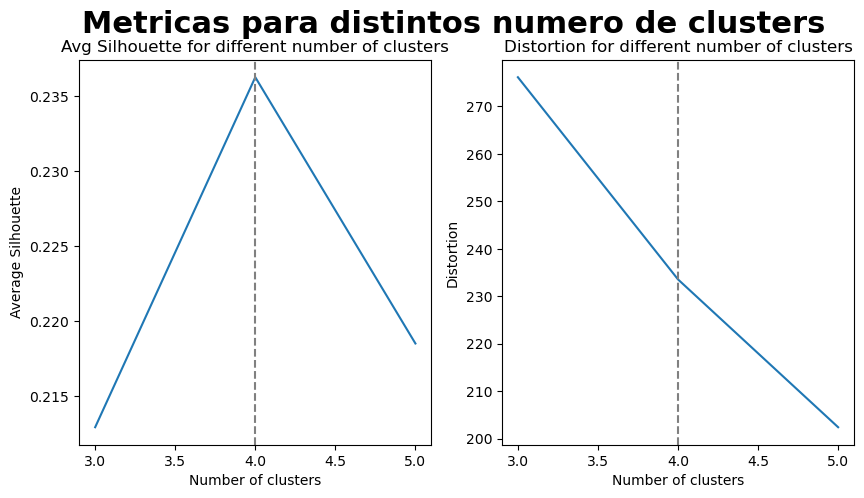

In [26]:
# evaluar cuantos metaclusters se podrian hacer
# opciones de metaclusters de clusters a checar


k_check = [3, 4, 5]

# variables para guardar las metricas a evaluar
avg_sil = []
distortions = []

# iterar en las opciones
for k in k_check:
    
    # hacer el modelo y obtener las etiquetas
    clusterer = KMeans(n_clusters = k, n_init = 10, random_state= 10)
    cluster_labels = clusterer.fit_predict(vectores_clusters)
    
    # añadir las metricas
    avg_sil.append(silhouette_score(vectores_clusters, cluster_labels))
    distortions.append(clusterer.inertia_)

    # imprimir progreso
    print(f'Progreso [{k}/{max(k_check)}]')

    
# tomar el indice del k con mejor score
indx_best = np.argmax(avg_sil)
# tomar el respectivo mejor k
k_best = k_check[indx_best]

# imprimir las metricas a travez del numero de clusters

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

# plor del Average Silhouette
ax1.plot(k_check, avg_sil)
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Average Silhouette')
ax1.set_title('Avg Silhouette for different number of clusters')
ax1.axvline(x=k_best, linestyle='dashed', color='gray')


# plot de la distorsion
ax2.plot(k_check, distortions)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Distortion')
ax2.set_title('Distortion for different number of clusters')
ax2.axvline(x=k_best, linestyle='dashed', color='gray')



fig.suptitle('Metricas para distintos numero de clusters', fontsize=22, fontweight='bold')

# salvar
nombre_save= 'Model Selection'

plt.show()

In [27]:
k = k_best

model = KMeans(n_clusters=k, n_init= 20, random_state= 10)
y = model.fit_predict(vectores_clusters)

In [28]:
# hacer un diccionario de los metaclusters
# es decir, con pares (meta_cluster, clusters_que_contiene)

metaclusters_dict = {}
# iterar en los meta-clusters
for i in range(k):
    # poner los clsuters que tiene
    metaclusters_dict[i] = list(np.array(buenos_clusters)[y == i])

In [29]:
# imprimi info
for i in range(k):
    print('Metacluster', i)
    print('Clusters que tiene:', metaclusters_dict[i])
    print("-"*100)

Metacluster 0
Clusters que tiene: [34, 47, 12, 36, 46, 7, 32, 48, 2, 28, 26, 30, 23, 37, 20, 15, 40, 18, 4, 39]
----------------------------------------------------------------------------------------------------
Metacluster 1
Clusters que tiene: [25, 42, 44, 17, 38, 9, 41, 24, 45, 0, 35]
----------------------------------------------------------------------------------------------------
Metacluster 2
Clusters que tiene: [22, 33, 13, 8]
----------------------------------------------------------------------------------------------------
Metacluster 3
Clusters que tiene: [10, 19, 43, 49, 31]
----------------------------------------------------------------------------------------------------


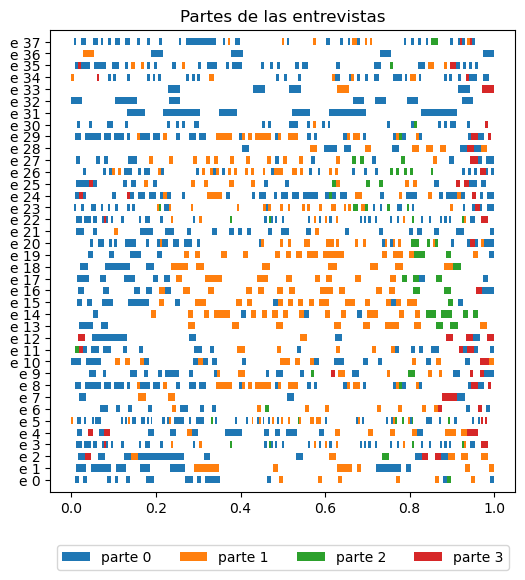

In [30]:
# ver los metaclusters
# es decir, ver las "partes de la entrevista"

fig, ax = plt.subplots(figsize = (6, 6))

# obtener un color por cada metacluster
colores_partes = get_colors(k)

# por cada metaclusters, graficar los clusters que contiene
for i in range(k):
    ver_clusters(metaclusters_dict[i], ax = ax, label = 'parte ' + str(i), color = colores_partes[i])

# Colocar la leyenda debajo de la gráfica
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
ax.set_title('Partes de las entrevistas')
plt.show()

In [31]:
idx = 26

e = entrevistas[idx]
preguntas_e = e.get_preguntas()
clusters_e = clusterizar(preguntas_e)

for p, c in zip(preguntas, clusters_e):
    
    if c in buenos_clusters:
        # tomar el meta cluster
        for m in metaclusters_dict:
            if c in metaclusters_dict[m]:
                meta = m
                
        imprimir_texto_con_color(p, colores_partes[meta])
        
    else:
        imprimir_texto_con_color(p, "white")